In [1]:
## AUDIO PROC
from scipy.io import wavfile
import numpy as np
import sys
import filtering
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
import math
import sounddevice as sd
import os
import matplotlib.pyplot as plt


## READ IN WAV, INITIAL DATA EXPLORATION

In [19]:
base_path = '/home/stargazer/Downloads/asa_data/'

audio_files = sorted(os.listdir(base_path))

print(audio_files)

## get the hydrophone data
samplerate, d1 = wavfile.read(os.path.join(base_path, 'SCP23_ Hyd N.wav'))
samplerate, d2 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd O.wav'))
samplerate, d3 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd P.wav'))

['SCP23_ Hyd N.wav', 'SCP23_Hyd O.wav', 'SCP23_Hyd P.wav']


<ipython-input-19-b00c87c24c99>:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, d1 = wavfile.read(os.path.join(base_path, 'SCP23_ Hyd N.wav'))
<ipython-input-19-b00c87c24c99>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, d2 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd O.wav'))
<ipython-input-19-b00c87c24c99>:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, d3 = wavfile.read(os.path.join(base_path, 'SCP23_Hyd P.wav'))


TIME IN SECONDS:  333.0


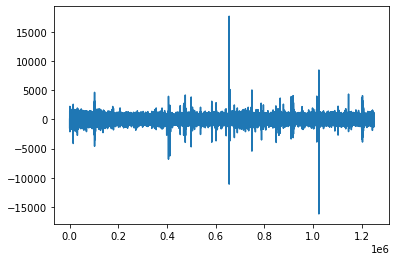

In [20]:
## get some stats

length = len(d1)/samplerate
print('TIME IN SECONDS: ', length)

## plot the first 5 seconds
plt.plot(d1[:int(5*samplerate)])

In [21]:
import noisereduce as nr

# d1 = nr.reduce_noise(y=d1, sr=samplerate)
# d2 = nr.reduce_noise(y=d2, sr=samplerate)
# d3 = nr.reduce_noise(y=d3, sr=samplerate)



NameError: name 'reduced_noise' is not defined

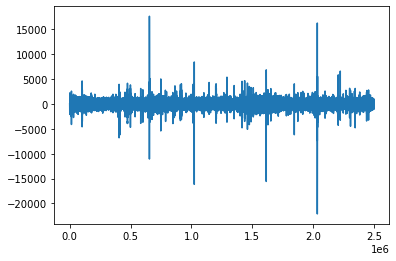

In [22]:
plt.plot(d1[0:int(10*samplerate)])
plt.plot(reduced_noise[0:int(10*samplerate)])

## SPECTROGRAM

In [23]:
import librosa
import librosa.display

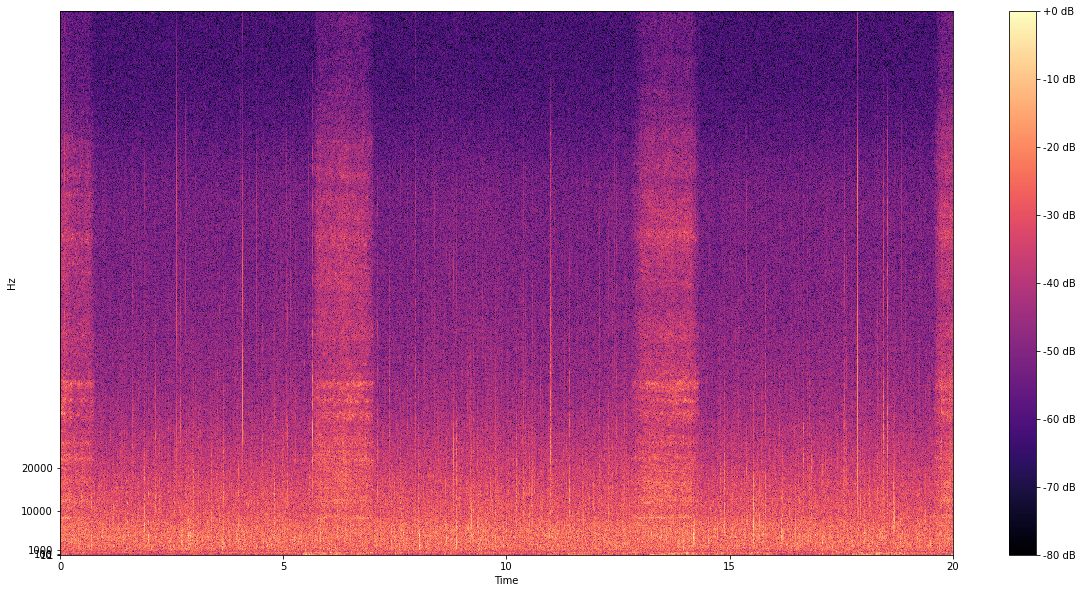

Text(0, 0.5, 'Frequency')

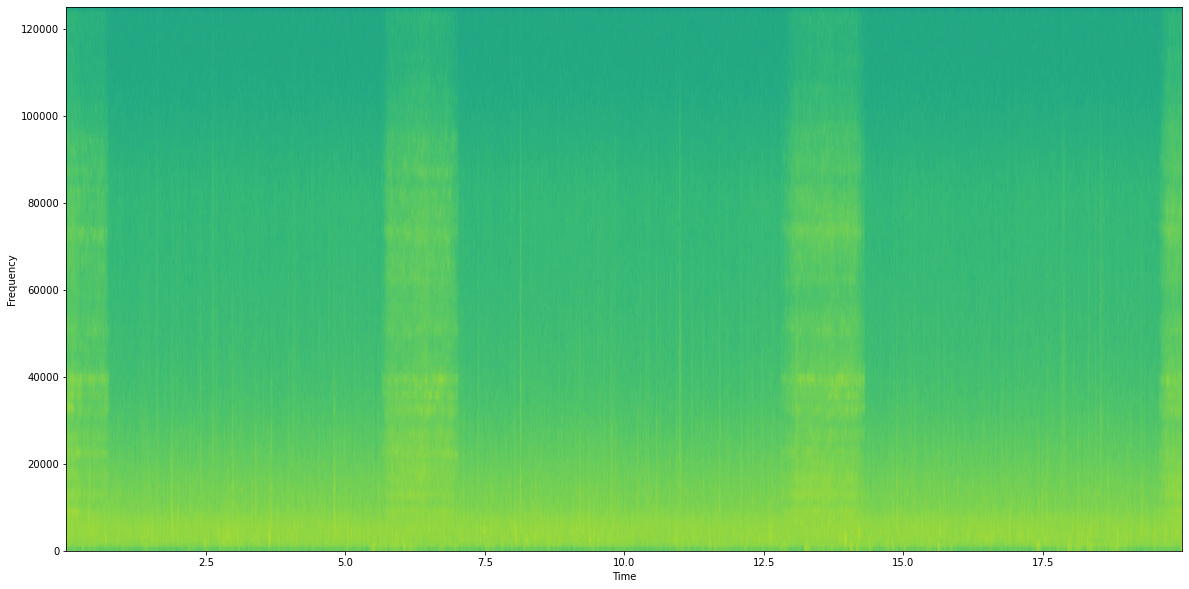

In [24]:
S = np.abs(librosa.stft(d1[:int(20*samplerate)].astype(np.float64)))

fig, ax = plt.subplots(figsize = (20,10))
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='linear',sr=samplerate, x_axis='time', ax=ax)
ax.set_yticks([1,10,100,1000,10000, 20000])
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

fig, ax = plt.subplots(figsize = (20,10))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(d1[:int(20*samplerate)], Fs=samplerate)
plt.xlabel('Time')
plt.ylabel('Frequency')



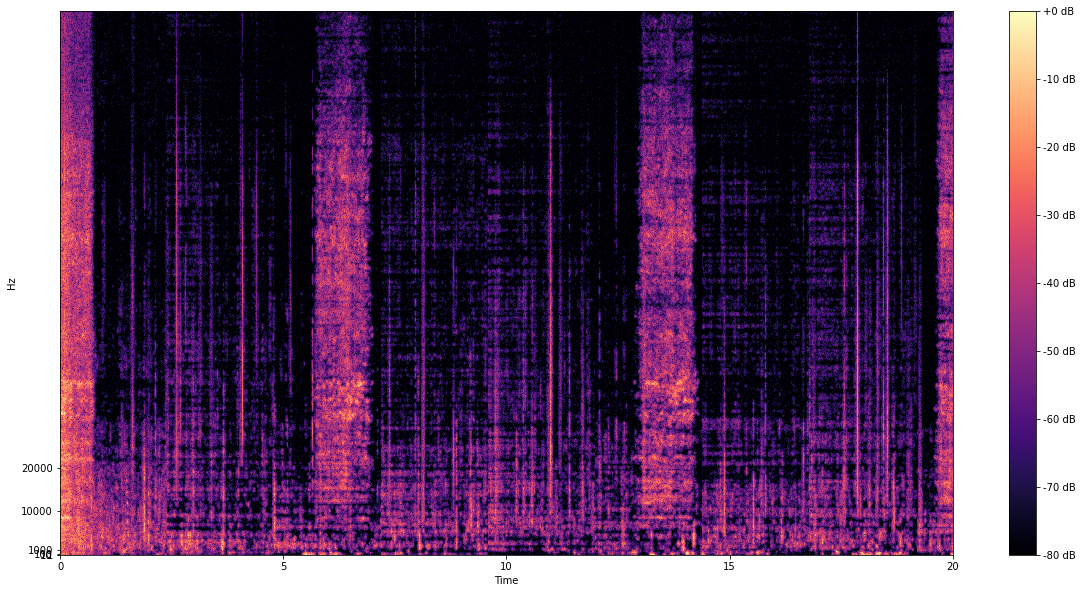

Text(0, 0.5, 'Frequency')

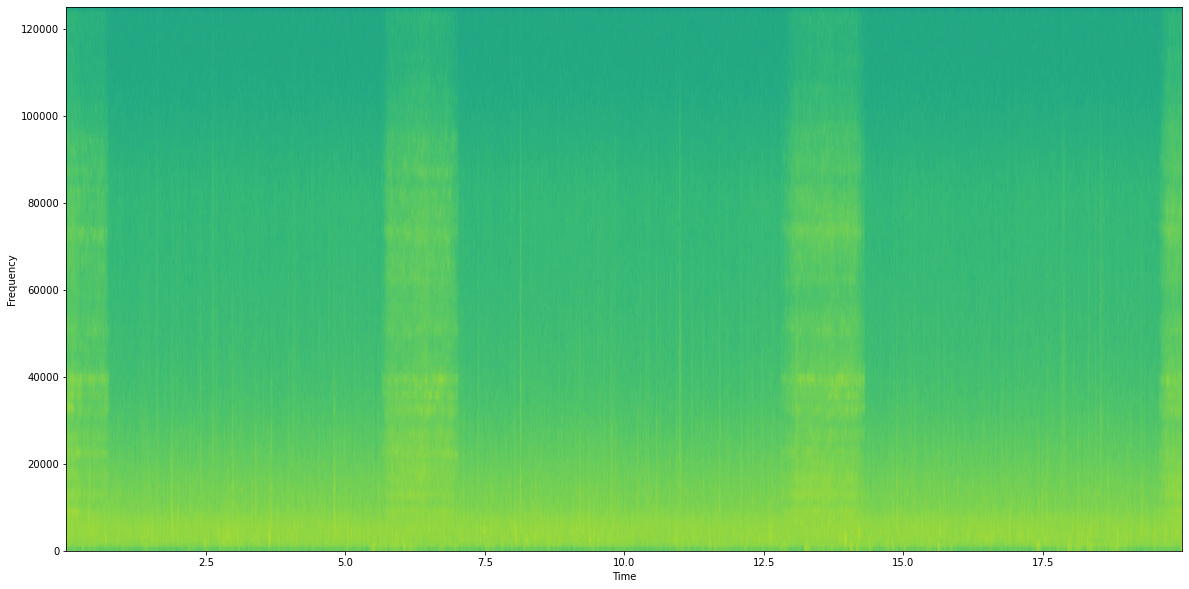

In [16]:
S = np.abs(librosa.stft(reduced_noise[:int(20*samplerate)].astype(np.float64)))

fig, ax = plt.subplots(figsize = (20,10))
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='linear',sr=samplerate, x_axis='time', ax=ax)
ax.set_yticks([1,10,100,1000,10000, 20000])
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

fig, ax = plt.subplots(figsize = (20,10))
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(d1[:int(20*samplerate)], Fs=samplerate)
plt.xlabel('Time')
plt.ylabel('Frequency')



In [17]:
d1 = reduced_noise

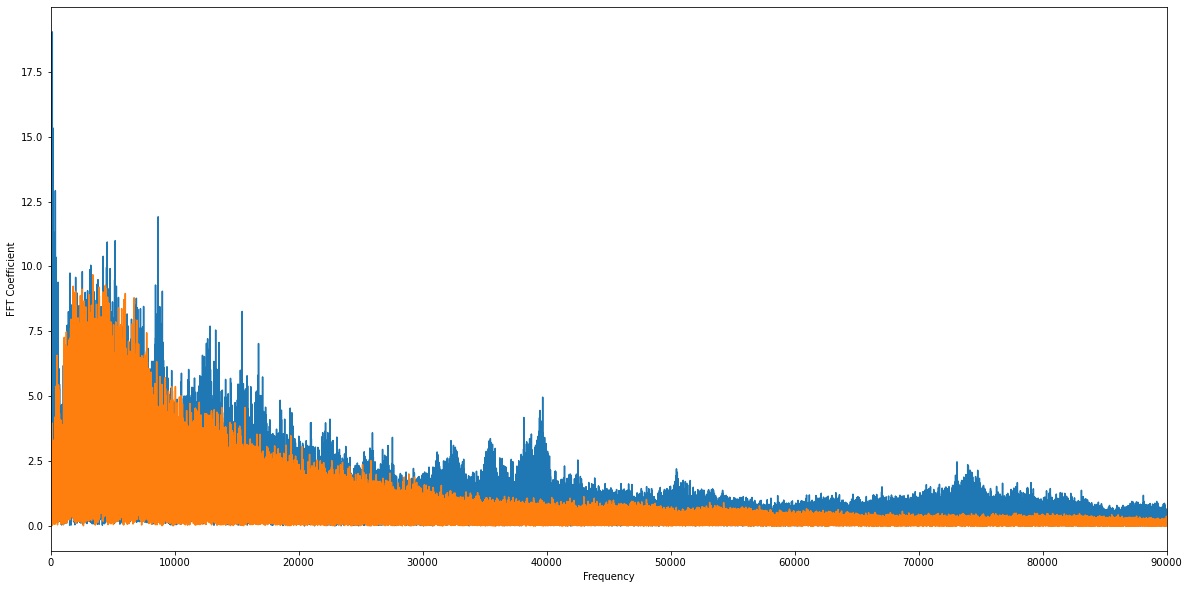

In [25]:
## FFT CHECK
import scipy
N = len(d1[int(5.5*samplerate):int(7.5*samplerate)])
T = 1/samplerate
yf = scipy.fftpack.fft(d1[int(13*samplerate):int(15*samplerate)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlim(0,90e3)
N = len(d1[int(9*samplerate):int(11*samplerate)])
T = 1/samplerate
yf = scipy.fftpack.fft(d1[int(9*samplerate):int(11*samplerate)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlabel('Frequency')
plt.ylabel('FFT Coefficient')
plt.show()



## TASK 2: PREPARE SOME DOA COMPUTATION

In [26]:
## mics N and P, check 1 second long frames
time = 1
overlap =1
segmented_N = (filtering.segment(d1[int(samplerate*0):int(samplerate*250)], 0, samplerate*(time), step = samplerate*(time)*overlap))
segmented_O = (filtering.segment(d2[int(samplerate*0):int(samplerate*250)], 0, samplerate*(time), step = samplerate*(time)*overlap ))
segmented_P = (filtering.segment(d3[int(samplerate*0):int(samplerate*250)], 0, samplerate*(time), step = samplerate*(time)*overlap ))

In [46]:
# store variables like some delays, powers
delays_NP = []
delays_OP = []
delays_NO = []

good_frame_delays_NO = []
good_frame_delays_NP = []
good_frame_delays_OP = []

powers_N = []
powers_O =[]
powers_P =[]
for i, (b1, b2,b3) in enumerate(zip(segmented_N, segmented_O, segmented_P)):
#     b3 = filtering.apply_bandpass(35e3, 40e3, b3, samplerate, 'bandpass')
#     b2 = filtering.apply_bandpass(35e3, 40e3, b2, samplerate, 'bandpass')
#     b1 = filtering.apply_bandpass(35e3, 40e3, b1, samplerate, 'bandpass')
    


    ## go through frames, generate GCC-PHAT lags
    lag_NP, cc3 = filtering.gcc_methods(b1, b3,fs=samplerate, interp = 1, beamform = True)
    delays_NP.append(lag_NP)
    
    lag_OP, cc3 = filtering.gcc_methods(b2, b3,fs=samplerate, interp = 1, beamform = True)
    delays_OP.append(lag_OP)
    
    lag_NO, cc3 = filtering.gcc_methods(b1, b2,fs=samplerate, interp = 1, beamform = True)
    delays_NO.append(lag_NO)
    
    thresh = 0.1e9
    
    # get energy in certain bands to select good frames, for each pair of hydrophones
    b4 = (b1+b2)/2
    f,y = filtering.get_f_Y(b1)
    ratio = filtering.get_breathing_band(f, np.abs(y), samplerate)
    ratio = np.sum(np.abs(b4**2))
    powers_N.append(np.sum(np.abs(b1**2)))
    if(ratio > thresh):
        good_frame_delays_NO.append(lag_NO)
    else:
        good_frame_delays_NO.append(np.nan)
    
    b4 = (b2+b3)/2
    f,y = filtering.get_f_Y(b2)
    ratio = filtering.get_breathing_band(f, np.abs(y), samplerate)
    ratio = np.sum(np.abs(b4**2))
    powers_O.append(np.sum(np.abs(b2**2)))
    if(ratio > thresh):
        good_frame_delays_OP.append(lag_OP)
    else:
        good_frame_delays_OP.append(np.nan)
    
    b4 = (b1+b3)/2
    f,y = filtering.get_f_Y(b3)
    ratio = filtering.get_breathing_band(f, np.abs(y), samplerate)
    ratio = np.sum(np.abs(b4**2))
    powers_P.append(np.sum(np.abs(b3**2)))
    if(ratio > thresh):
        good_frame_delays_NP.append(lag_NP)
    else:
        good_frame_delays_NP.append(np.nan)

order = 1
delays_NP= ndimage.median_filter(np.array(delays_NP), order)
delays_OP= ndimage.median_filter(np.array(delays_OP), order)
delays_NO= ndimage.median_filter(np.array(delays_NO), order)


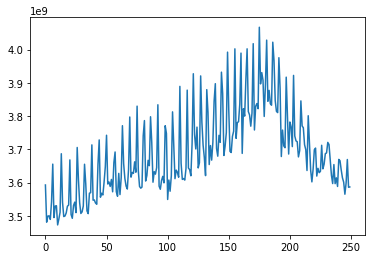

In [47]:
plt.plot(powers_N)
import pandas as pd
order = 10


delays_NP= ndimage.median_filter(np.array(delays_NP), order)
delays_OP= ndimage.median_filter(np.array(delays_OP), order)
delays_NO= ndimage.median_filter(np.array(delays_NO), order)

good_frame_delays_NP= ndimage.median_filter(pd.Series(np.array(delays_NP)).interpolate(), order)
good_frame_delays_OP= ndimage.median_filter(pd.Series(np.array(delays_OP)).interpolate(), order)
good_frame_delays_NO= ndimage.median_filter(pd.Series(np.array(delays_NO)).interpolate(), order)


(0.0, 220.0)

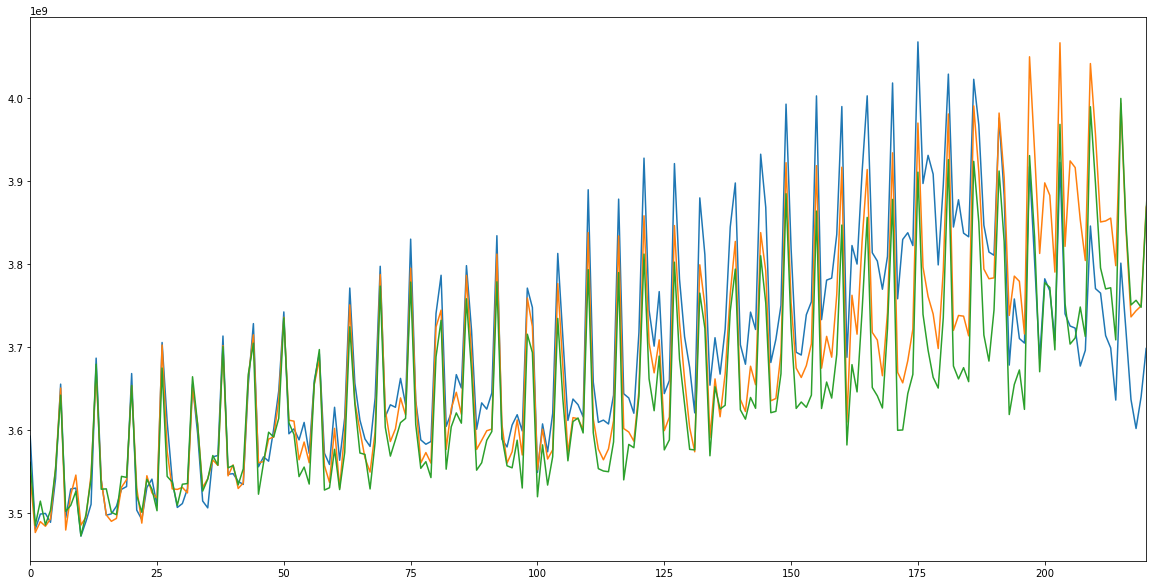

In [48]:
plt.figure(figsize=(20,10))
xs = np.arange(0,len(powers_N))

plt.plot(time*xs*overlap,powers_N)
plt.plot(time*xs*overlap,powers_O)
plt.plot(time*xs*overlap,powers_P)
plt.xlim(0,220)


In [49]:
150 + np.argmax(powers_O)/(time*overlap)

353.0

<ipython-input-84-a1e3311c852e>:18: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*d) )
<ipython-input-84-a1e3311c852e>:25: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d/2)) )
<ipython-input-84-a1e3311c852e>:32: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d/2)) )
<ipython-input-84-a1e3311c852e>:41: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d*2)))
<ipython-input-84-a1e3311c852e>:48: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d)) )
<ipython-input-84-a1e3311c852e>:55: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x*v/(samplerate*(d)) )


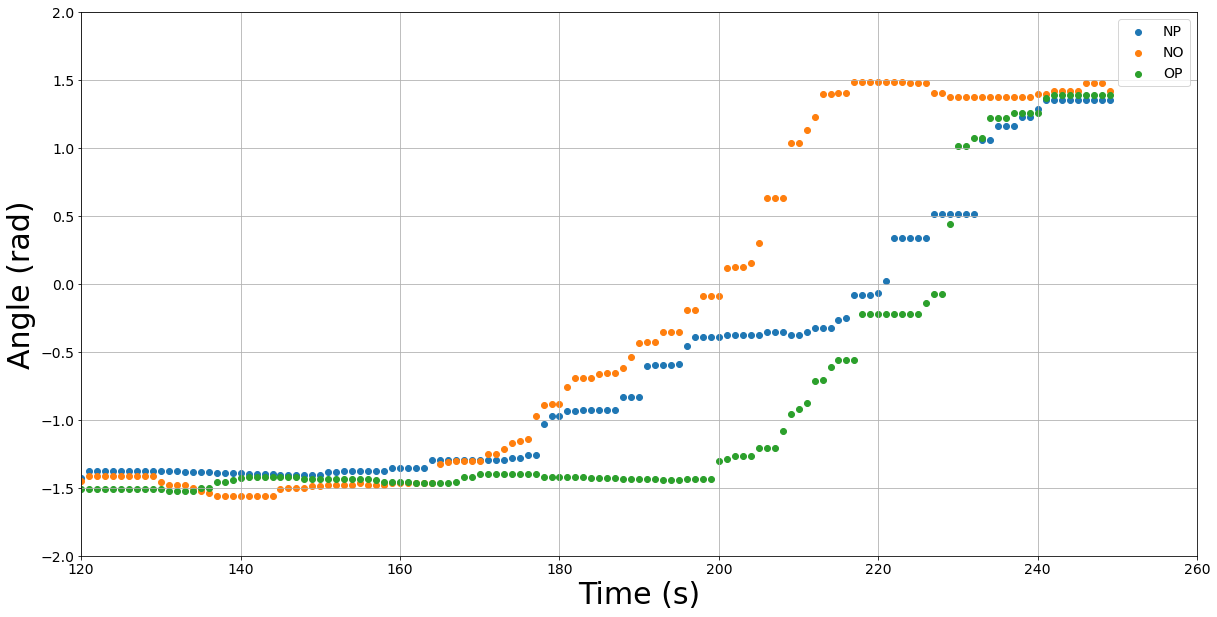

In [84]:
import pandas as pd
v = 1520
d = 28
angles_NO = []
angles_NP = []
angles_OP = []
good_frame_angles_NP=[]
good_frame_angles_NO=[]

good_frame_angles_OP=[]

# theta = np.arcsin(tau*v)/d

for i, x in enumerate(delays_NP):
    if(np.isnan(x)):
        angles_NP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*d) )  
        angles_NP.append(theta)

for i, x in enumerate(delays_NO):
    if(np.isnan(x)):
        angles_NO.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d/2)) )  
        angles_NO.append(theta)
        
for i, x in enumerate(delays_OP):
    if(np.isnan(x)):
        angles_OP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d/2)) )  
        angles_OP.append(theta)
        
        
        
for i, x in enumerate(good_frame_delays_NP):
    if(np.isnan(x)):
        good_frame_angles_NP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d*2)))  
        good_frame_angles_NP.append(theta)
        
for i, x in enumerate(good_frame_delays_NO):
    if(np.isnan(x)):
        good_frame_angles_NO.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d)) )  
        good_frame_angles_NO.append(theta)
        
for i, x in enumerate(good_frame_delays_OP):
    if(np.isnan(x)):
        good_frame_angles_OP.append(np.nan)
    else:
        theta = np.arcsin(x*v/(samplerate*(d)) )  
        good_frame_angles_OP.append(theta)
        
xs = np.arange(0,len(good_frame_angles_NP))

plt.figure(figsize = (20,10))


# plt.plot(time*xs*overlap, pd.Series(np.array(angles_OP)).interpolate(), label = 'OP')
# plt.plot(time*xs*overlap, pd.Series(np.array(angles_NO)).interpolate(), label = 'NO')
# plt.plot(time*xs*overlap, pd.Series(np.array(angles_NP)).interpolate(), label = 'NP')

# plt.plot(time*xs*overlap, pd.Series(np.array(good_frame_angles_OP)).interpolate(), label = 'OP')
# plt.plot(time*xs*overlap, pd.Series(np.array(good_frame_angles_NO)).interpolate(), label = 'NO')
# plt.plot(time*xs*overlap, pd.Series(np.array(good_frame_angles_NP)).interpolate(), label = 'NP')

plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NP)).interpolate(), label = 'NP')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NO)).interpolate(), label = 'NO')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_OP)).interpolate(), label = 'OP')



plt.ylim(-2,2)
plt.xlim(120,260)

plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Time (s)', size = 30)
plt.ylabel('Angle (rad)', size = 30)
plt.show()

In [85]:
## speed check

t1 = np.nanargmin(np.abs(good_frame_angles_NO))
t2 = np.nanargmin(np.abs(good_frame_angles_NP))
t3 = np.nanargmin(np.abs(good_frame_angles_OP))

t1, t2, t3

# v = d/t
v1 = (7/(t2-t1))
print(v1)

v2 = (7/(t3-t2))
print(v2)

v3 = (14/(t3-t1))
print(v3)

0.30434782608695654
1.1666666666666667
0.4827586206896552


In [86]:
t2, t1

(221, 198)

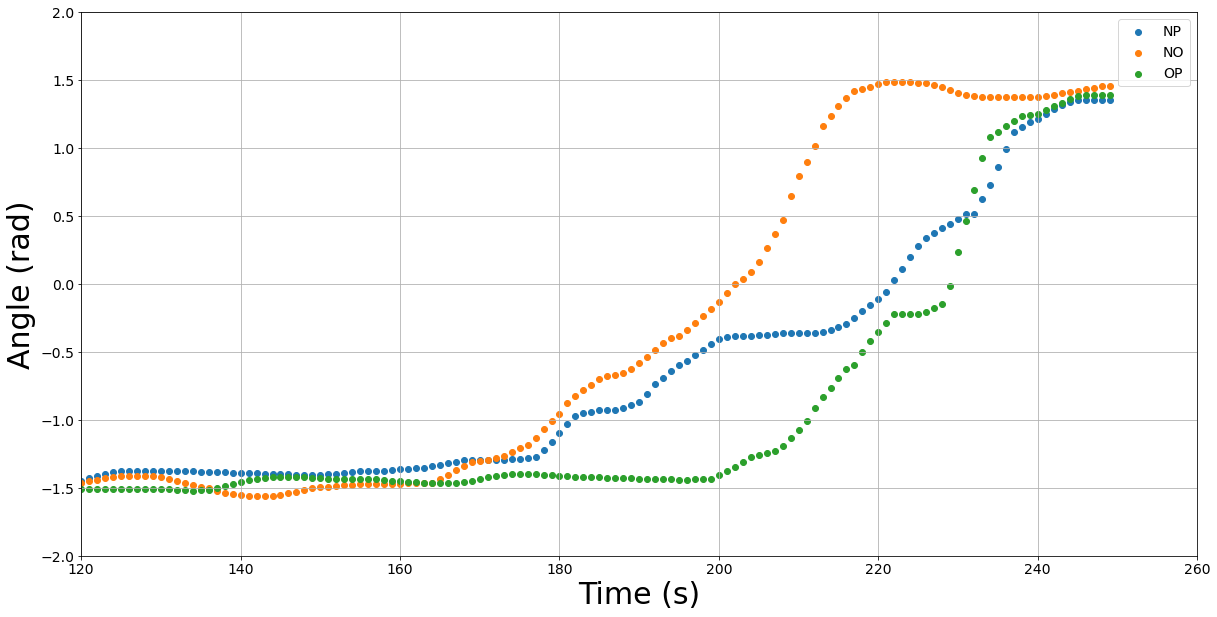

In [134]:
xs = np.arange(0,len(good_frame_angles_NP))

plt.figure(figsize = (20,10))

plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NP)).interpolate().rolling(5).mean(), label = 'NP')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NO)).interpolate().rolling(5).mean(), label = 'NO')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_OP)).interpolate().rolling(5).mean(), label = 'OP')



plt.ylim(-2,2)
plt.xlim(120,260)

plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Time (s)', size = 30)
plt.ylabel('Angle (rad)', size = 30)
plt.show()

22


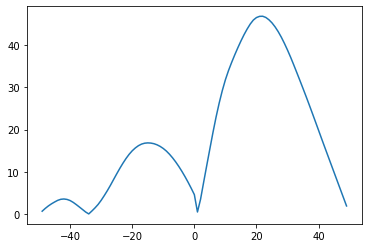

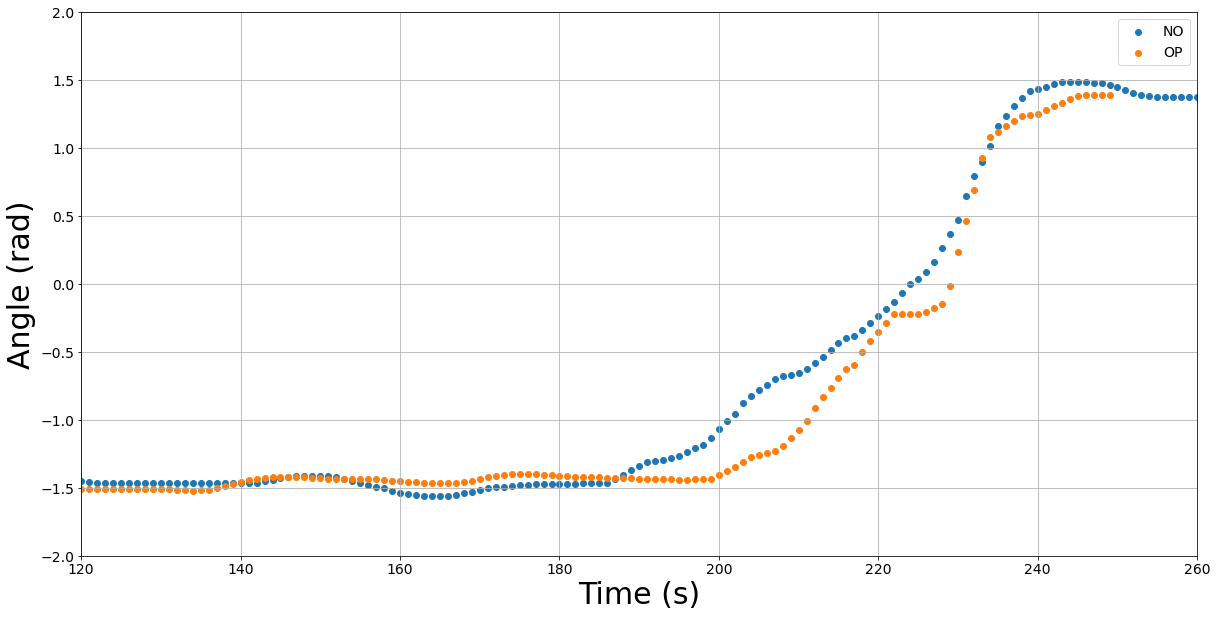

0.6363636363636364

In [151]:
x1 =  pd.Series(np.array(good_frame_angles_NO)).interpolate().rolling(5).mean().bfill()[190:240]
x2 = pd.Series(np.array(good_frame_angles_OP)).interpolate().rolling(5).mean().bfill()[190:240]
x3 = pd.Series(np.array(good_frame_angles_NP)).interpolate().rolling(5).mean().bfill()[190:240]


corr = signal.correlate(x1, x2)
lags = signal.correlation_lags(len(x1), len(x2))

plt.plot(lags, abs(corr))
print(lags[np.argmax(abs(corr))])

#lags[np.argmax(corr)]

xs = np.arange(0,len(good_frame_angles_NP))

plt.figure(figsize = (20,10))

plt.scatter(time*xs*overlap + 22, pd.Series(np.array(good_frame_angles_NO)).interpolate().rolling(5).mean(), label = 'NO')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_OP)).interpolate().rolling(5).mean(), label = 'OP')



plt.ylim(-2,2)
plt.xlim(120,260)

plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Time (s)', size = 30)
plt.ylabel('Angle (rad)', size = 30)
plt.show()

14/22

22


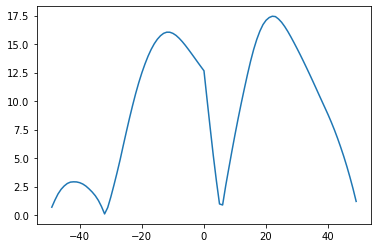

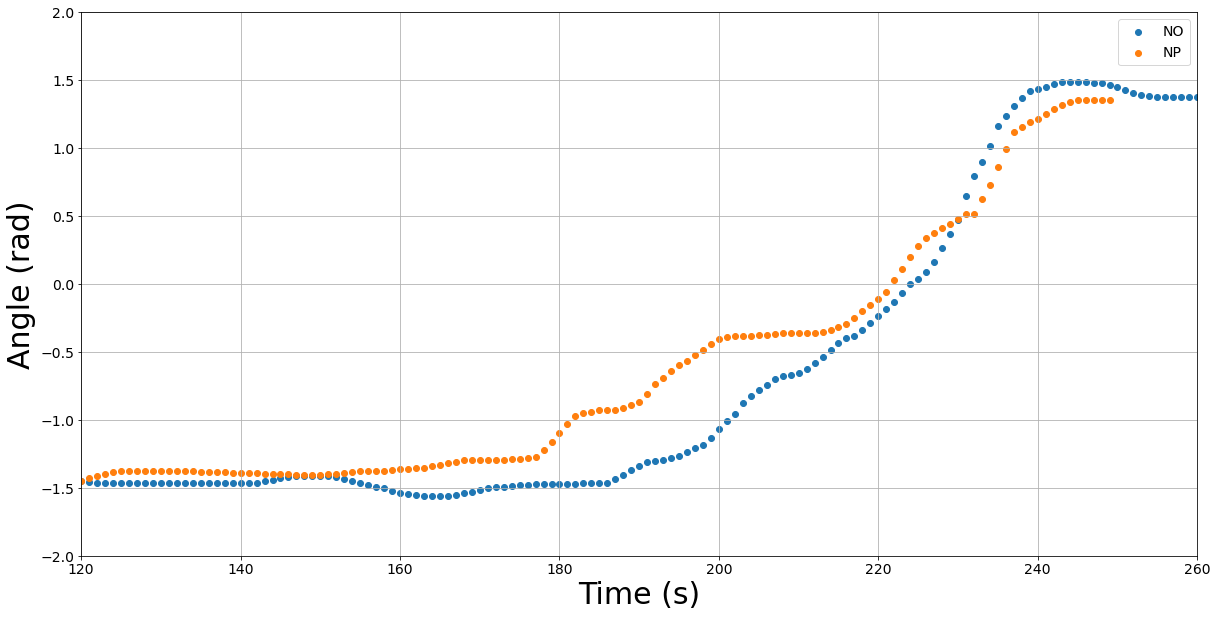

0.6363636363636364

In [136]:
x1 =  pd.Series(np.array(good_frame_angles_NO)).interpolate().rolling(5).mean().bfill()[190:240]
x2 = pd.Series(np.array(good_frame_angles_NP)).interpolate().rolling(5).mean().bfill()[190:240]

corr = signal.correlate(x1, x3)
lags = signal.correlation_lags(len(x1), len(x2))

plt.plot(lags, abs(corr))
print(lags[np.argmax(abs(corr))])

#lags[np.argmax(corr)]

xs = np.arange(0,len(good_frame_angles_NP))

plt.figure(figsize = (20,10))

plt.scatter(time*xs*overlap + lags[np.argmax(abs(corr))], pd.Series(np.array(good_frame_angles_NO)).interpolate().rolling(5).mean(), label = 'NO')
plt.scatter(time*xs*overlap, pd.Series(np.array(good_frame_angles_NP)).interpolate().rolling(5).mean(), label = 'NP')



plt.ylim(-2,2)
plt.xlim(120,260)

plt.grid()
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Time (s)', size = 30)
plt.ylabel('Angle (rad)', size = 30)
plt.show()

14/22

In [153]:
np.argmin(abs(x1)),np.argmin(abs(x2))

(12, 39)

In [154]:
t = 190+22

x1[t], x2[t]

(1.0141095625429493, -0.9091962366668241)

In [157]:
7/np.tan(np.pi-x1[t]),7/np.tan(np.pi-x2[t])

(-4.356404715564336, 5.450703926361429)

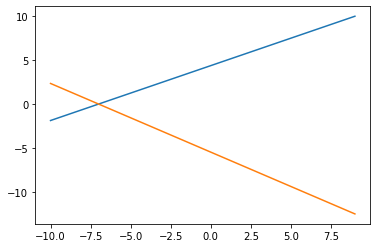

In [161]:
x = np.arange(-10,10)
y1 = (1/np.tan(x1[t]))*x + 7/np.tan(x1[t])
plt.plot(x,y1)

y2 = (1/np.tan(x2[t]))*x + 7/np.tan(x2[t])
plt.plot(x,y2)

In [16]:
203/overlap

203.0

In [17]:
# get DOA at similar times from each pair to triangulate an altitude
idx1 = np.where(~np.isnan(good_frame_angles_NO))
idx2 = np.where(~np.isnan(good_frame_angles_OP))
idx3 = np.where(~np.isnan(good_frame_angles_NP))


In [18]:
# point where two rays intersect
y1[np.argmin(abs(y1-y2))]

NameError: name 'y1' is not defined

-1.4143220435930737 -1.3780700999453668 -0.7363970251607052


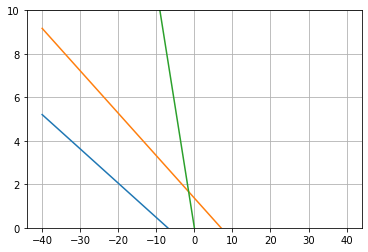

In [658]:
a1 = good_frame_angles_NO[int((187-150)/(time*overlap))]
a2= good_frame_angles_OP[int((187-150)/(time*overlap))]
a3= good_frame_angles_NP[int((187-150)/(time*overlap))]

print(a1,a2, a3)

x = np.arange(-40,40,0.01)

y1 = np.tan(np.pi/2-a1)*(x+7)
y2 = np.tan(np.pi/2-a2)*(x-7)
y3 = np.tan(np.pi/2-a3)*(x)


plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)

plt.ylim(0,10)
plt.grid()

In [659]:
# point where two rays intersect
y1[np.argmin(abs(y1-y2))], y1[np.argmin(abs(y1-y3))]

(-7.413328700659327, -1.2889315914949242)

0.12715379060070015 -1.2631204794989574 -0.37808657046128347


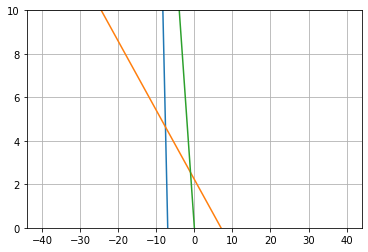

In [671]:
a1 = good_frame_angles_NO[int((203)/(time*overlap))]
a2= good_frame_angles_OP[int((203)/(time*overlap))]
a3= good_frame_angles_NP[int((203)/(time*overlap))]

print(a1,a2, a3)

x = np.arange(-40,40,0.01)

y1 = np.tan(a1-(np.pi/2))*(x+7)
y2 = np.tan(-a2+(np.pi/2))*(x-7)
y3 = np.tan(-a3+np.pi/2)*(x)


plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)

plt.ylim(0,10)
plt.grid()

In [653]:
# point where two rays intersect
y2[np.argmin(abs(y1-y2))]

0.4134763337506901

1.4841832130407513 -0.22266979227937111 -0.06518901863083151


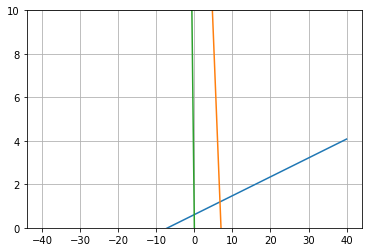

In [640]:
a1 = good_frame_angles_NO[int((220-150)/(time*overlap))]
a2= good_frame_angles_OP[int((220-150)/(time*overlap))]
a3= good_frame_angles_NP[int((220-150)/(time*overlap))]

print(a1,a2, a3)

x = np.arange(-40,40,0.01)

y1 = np.tan(np.pi/2-a1)*(x+7)
y2 = np.tan(np.pi/2-a2)*(x-7)
y3 = np.tan(np.pi/2-a3)*(x)


plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)

plt.ylim(0,10)
plt.grid()

In [613]:
# point where two rays intersect
y2[np.argmin(abs(y1-y2))]

13.631149112605655